In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization,AveragePooling2D
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2024-06-23 18:54:59.968330: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 18:54:59.968436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 18:55:00.251103: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


# **Additional Information**

In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


# **Preparation**
## Importing Dataset

In [3]:
#generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels

# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [4]:
def create_gens (train_df, valid_df, test_df, batch_size):
#This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.Image data generator converts images into tensors.


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [5]:
def get_dataset(path, image_width=224, image_height=224, batch_size=64): 

    train_ds=tf.keras.utils.image_dataset_from_directory(
        path,
        validation_split=0.2,
        subset='training',
        seed=123,
        image_size=(image_width, image_height),
        batch_size=batch_size)
    
    val_ds=tf.keras.utils.image_dataset_from_directory(
        path,
        validation_split=0.2,
        subset='validation',
        seed=123,
        image_size=(image_width, image_height),
        batch_size=batch_size)
    
    return train_ds,val_ds

## Setting GPU

In [6]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Displaying Dataset Images

In [7]:
def show_images(df):
#This function take the data generator and show sample of the images
    class_names = df.class_names
    # return classes , images to be displayed
    # calculate number of displayed samples
    length = len(class_names)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images
    
    plt.figure(figsize=(20, 20))
    for images, labels in df.take(1):
        for i in range(sample):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

## Callbacks
Need to be Fixed

In [8]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self._model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.learning_rate)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc','Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = self.model.optimizer.learning_rate # get the current learning rate, NOTE: In 2.15.x get_value is deprecated
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    self.model.optimizer.learning_rate = lr # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    self.model.optimizer.learning_rate = lr # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = 'H'
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

## Training Plot Function

In [9]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

# **Start Working**
## Reading Dataset

In [10]:
img_width = 224
img_height = 224
batch_size = 32
path = ('/kaggle/input/paddy-doctor/paddy-disease-classification/train_images')
train_ds, val_ds = get_dataset(path)

Found 10407 files belonging to 10 classes.
Using 8326 files for training.
Found 10407 files belonging to 10 classes.
Using 2081 files for validation.


## Images Sample


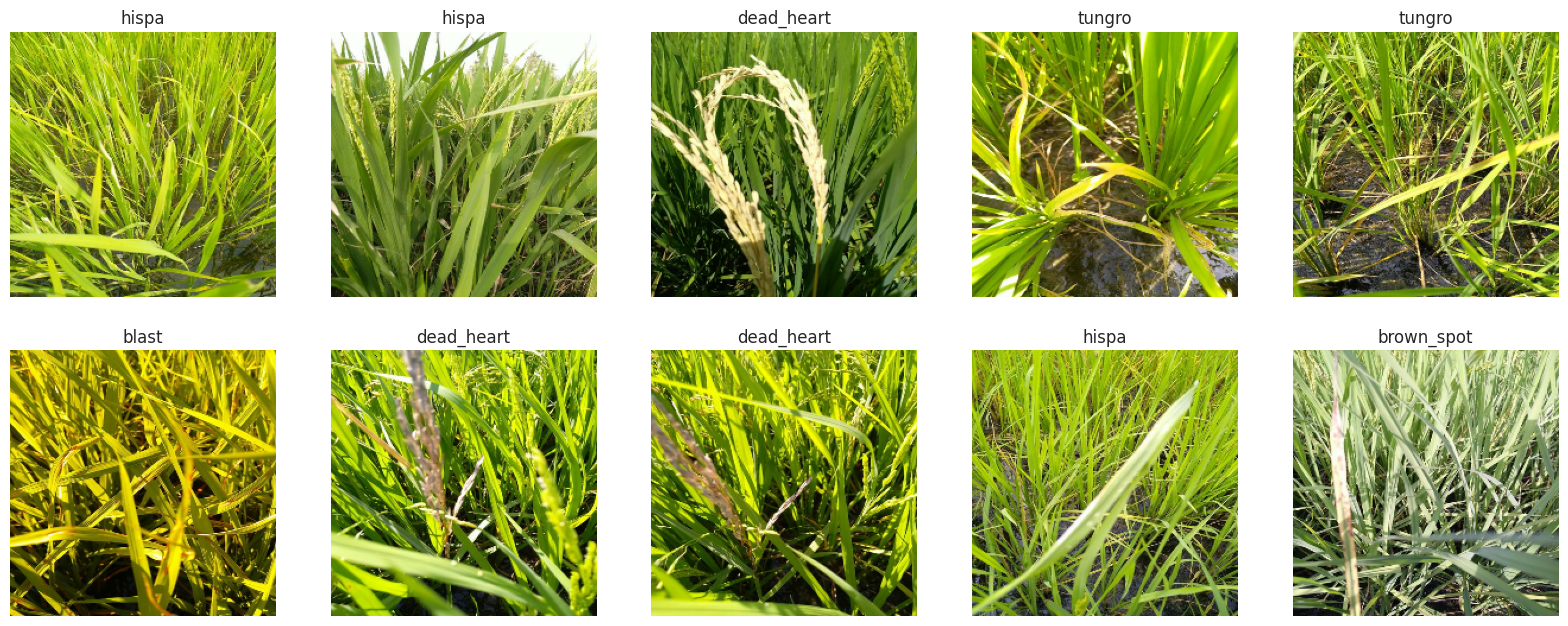

In [11]:
show_images(train_ds)

## All Categories List

In [12]:
print("Class names:", train_ds.class_names)

Class names: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


## Generic Model Builder
### Efficient Net B3

In [13]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_ds.class_names)) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
# base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = True 
# model = Sequential([
#     base_model,
#     BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
#     Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
#                 bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
#     Dense(class_count, activation= 'softmax')
# ])

# model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
# model.build(input_shape=(None, img_size[0], img_size[1], channels))
# model.summary()

### Efficient Net B4

In [14]:
# Load the pre-trained EfficientNetB4 model without the top classification layer
base_model = tf.keras.applications.efficientnet.EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained base model layers
base_model.trainable = False

model = Sequential([
    base_model,
    MaxPooling2D(),
    Flatten(), 
    Dense(220, activation='relu'),
    Dropout(0.25),
    Dense(class_count, activation= 'softmax')
])
model.compile(optimizer='adam', loss= tf.keras.losses.sparse_categorical_crossentropy , metrics= ['accuracy'])
model.build(input_shape=(None, img_size[0], img_size[1], channels))
model.summary()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 7, 7, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 1792)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 220)            │     3,548,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 220)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,224,413 (80.96 MB)

 Trainable params: 3,550,590 (13.54 MB)

 Non-trainable params: 17,673,823 (67.42 MB)

### CNN

In [15]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')
])

# model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics= ['accuracy'])
model_cnn.compile(optimizer='adam', loss= tf.keras.losses.sparse_categorical_crossentropy , metrics= ['accuracy'])
model_cnn.build(input_shape=(None, img_size[0], img_size[1], channels))
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 111, 111, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 396,794 (1.51 MB)

 Trainable params: 396,794 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

## Setting Callbacks

In [16]:
batch_size = 64   # set batch size for training
epochs = 30   # number of all epochs in training
patience = 2   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 30   # nu|mber of epochs to run before asking if you want to halt training

In [17]:
# Get the number of batches in the training dataset
num_batches = tf.data.experimental.cardinality(train_ds).numpy()

print(f'Number of batches in the training dataset: {num_batches}')

# Calculate total number of images
total_images = num_batches * batch_size
# Adjust if the last batch has fewer images
if train_ds.cardinality() > 0:
    last_batch_size = len(list(train_ds.as_numpy_iterator())[-1][0])
    if last_batch_size != batch_size:
        total_images = (num_batches - 1) * batch_size + last_batch_size

print(f'Total number of images in the training dataset: {total_images}')

Number of batches in the training dataset: 131
Total number of images in the training dataset: 8326


In [18]:
batches = int(np.floor(total_images  / batch_size))
callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

## Training Start 😊
### EfficientNet

In [19]:
history = model.fit(x= train_ds, epochs= epochs, callbacks = callbacks, 
                    validation_data= val_ds, verbose = 0)

 Epoch     Loss   Accuracy  V_loss    V_acc   Monitor % Improv  Duration 


I0000 00:00:1719169087.726683      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719169087.835476      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


W0000 00:00:1719169166.842240      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


W0000 00:00:1719169178.790528      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719169202.152085      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 1 /30     1.716   46.433   0.96339  70.014   accuracy     0.00    204.79 
 2 /30     1.006   65.566   0.72242  78.376   accuracy    41.21    28.88  
 3 /30     0.772   74.466   0.63606  81.403   accuracy    13.57    29.31  
 4 /30     0.653   78.417   0.53294  83.950   accuracy     5.31    28.84  
 5 /30     0.565   80.855   0.50832  84.238   accuracy     3.11    28.95  
 6 /30     0.529   82.044   0.49065  84.431   accuracy     1.47    29.05  
 7 /30     0.447   85.083   0.40127  88.515   accuracy     3.70    28.86  
 8 /30     0.395   86.668   0.41042  87.746   accuracy     1.86    29.01  
 9 /30     0.390   87.101   0.40482  87.602   accuracy     0.50    29.01  
10 /30     0.358   88.398   0.38469  88.419   accuracy     1.49    28.93  
11 /30     0.368   87.005   0.37050  88.659   accuracy    -1.58    28.88  
12 /30     0.299   89.671   0.33247  90.918   accuracy     1.44    29.15  
13 /30     0.267   91.040   0.32731  90.437   val_loss     1.55    28.95  
14 /30     0.272   90.680

### CNN

In [20]:
callbacks = [MyCallback(model= model_cnn, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [21]:
history_cnn = model_cnn.fit(x= train_ds, epochs= epochs, callbacks = callbacks, 
                    validation_data= val_ds, verbose = 0)

 Epoch     Loss   Accuracy  V_loss    V_acc   Monitor % Improv  Duration 


W0000 00:00:1719170088.600805      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


W0000 00:00:1719170116.679726      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


W0000 00:00:1719170117.648897      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719170127.262911      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 1 /30     2.016   27.540   1.74905  39.837   accuracy     0.00    68.39  
 2 /30     1.539   47.466   1.31645  55.550   accuracy    72.35    24.29  
 3 /30     1.226   58.900   1.09199  64.296   accuracy    24.09    23.77  
 4 /30     0.964   67.487   1.02056  68.140   accuracy    14.58    24.01  
 5 /30     0.807   73.409   0.91982  71.312   accuracy     8.77    23.83  
 6 /30     0.673   77.756   0.73075  78.328   accuracy     5.92    23.81  
 7 /30     0.596   79.642   0.70350  79.289   accuracy     2.43    23.87  
 8 /30     0.496   83.269   0.73901  78.856   accuracy     4.55    23.86  
 9 /30     0.464   84.398   0.68899  79.865   accuracy     1.36    23.91  
10 /30     0.402   86.308   0.64368  81.836   accuracy     2.26    23.86  
11 /30     0.373   87.605   0.61039  83.229   accuracy     1.50    23.83  
12 /30     0.317   89.383   0.62043  84.383   accuracy     2.03    23.88  
13 /30     0.287   90.500   0.63947  83.710   val_loss    -4.76    23.81  
14 /30     0.275   90.908

## Display Model Performance
### Efficient Net B4

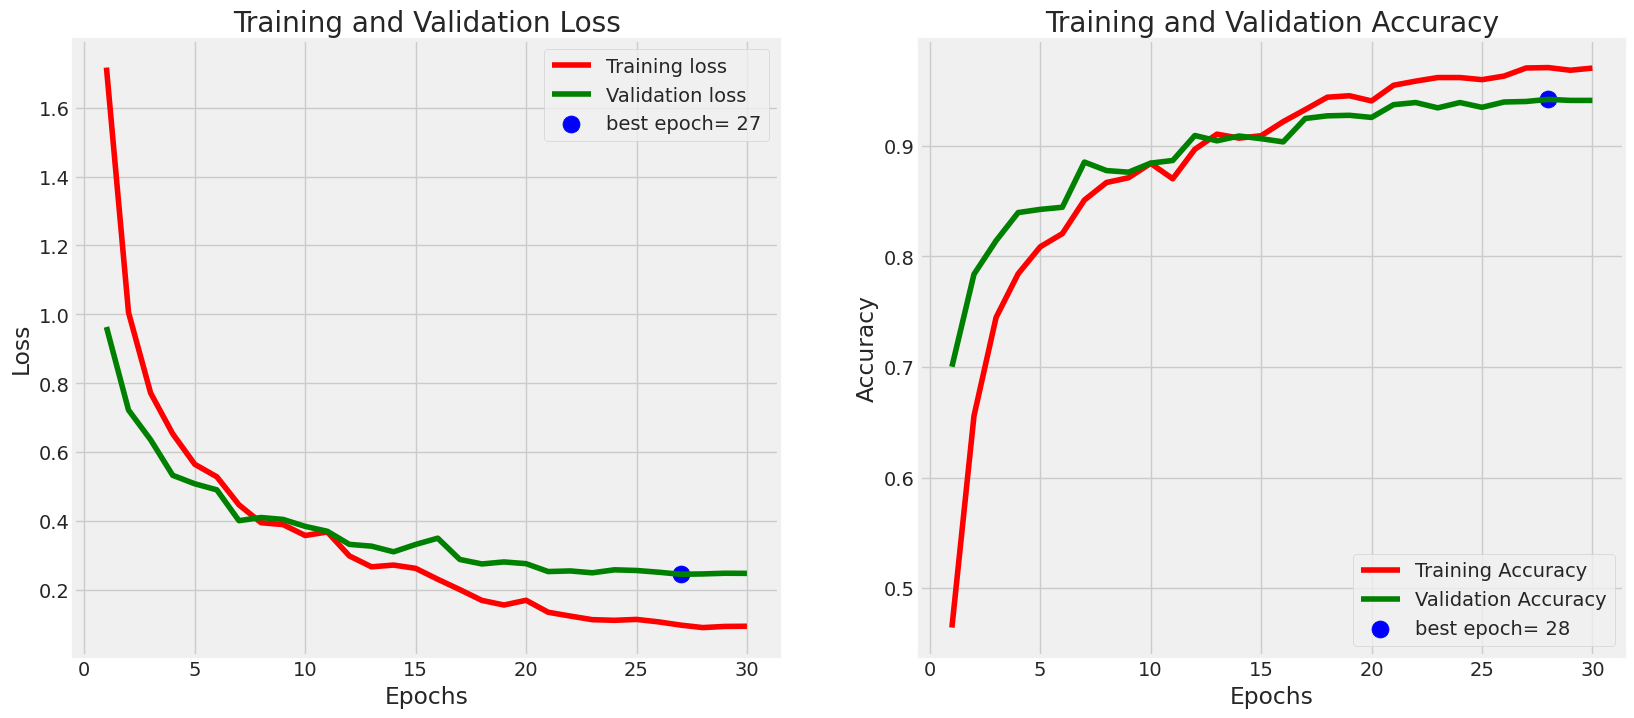

In [22]:
plot_training(history)

### CNN

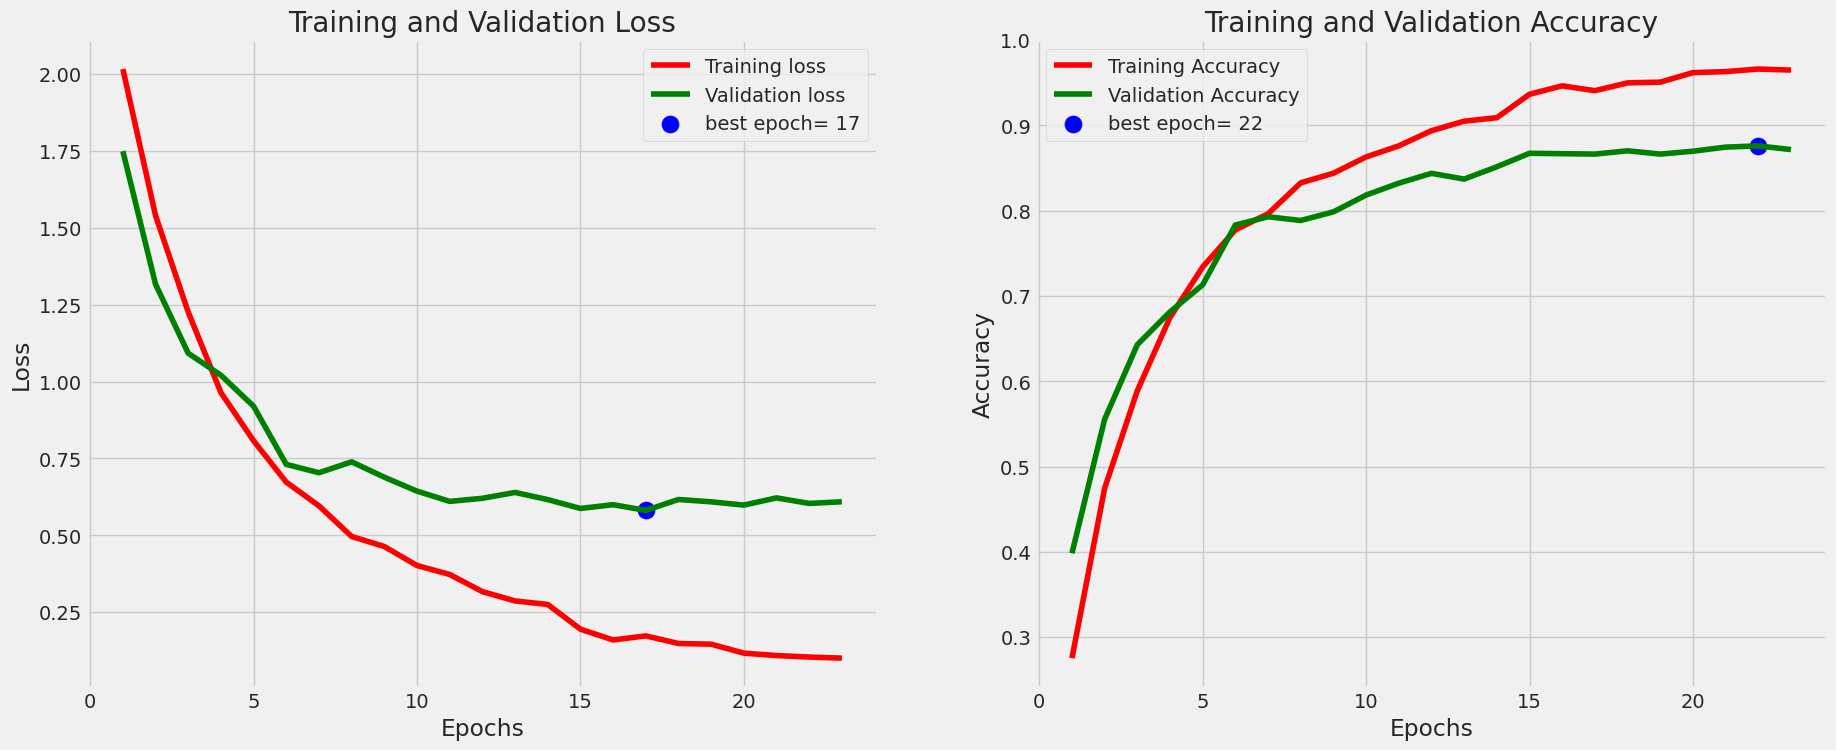

In [23]:
plot_training(history_cnn)

## Model Evaluation
### Efficient Net B4

In [24]:
# Get the number of batches in the validation dataset
num_batches = tf.data.experimental.cardinality(val_ds).numpy()

print(f'Number of batches in the validation dataset: {num_batches}')

# Calculate total number of images
total_images = num_batches * batch_size
# Adjust if the last batch has fewer images
if val_ds.cardinality() > 0:
    last_batch_size = len(list(val_ds.as_numpy_iterator())[-1][0])
    if last_batch_size != batch_size:
        total_images = (num_batches - 1) * batch_size + last_batch_size

print(f'Total number of images in the validation dataset: {total_images}')

Number of batches in the validation dataset: 33
Total number of images in the validation dataset: 2081


In [25]:
ts_length = total_images
test_batch_size = num_batches
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_ds, steps= test_steps, verbose= 1)
valid_score = model.evaluate(val_ds, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.9948 - loss: 0.0211
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.9363 - loss: 0.2511 
Train Loss:  0.01718209870159626
Train Accuracy:  0.9952877163887024
--------------------
Validation Loss:  0.24563950300216675
Validation Accuracy:  0.9399327039718628


### CNN 

In [26]:
train_score = model_cnn.evaluate(train_ds, steps= test_steps, verbose= 1)
valid_score = model_cnn.evaluate(val_ds, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9936 - loss: 0.0316
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8618 - loss: 0.6080
Train Loss:  0.031063957139849663
Train Accuracy:  0.9930555820465088
--------------------
Validation Loss:  0.5809876918792725
Validation Accuracy:  0.8664103746414185


## Save Model
### Efficient Net B4

In [27]:
model_name = model.layers[0].name
subject = 'Rice Disease'
acc = 0.945 * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}.weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as efficientnetb4-Rice Disease-94.50.h5
weights were saved as efficientnetb4-Rice Disease.weights.h5


### CNN

In [28]:
model_name = "CNN"
subject = 'Rice Disease'
acc = valid_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model_cnn.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}.weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model_cnn.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as CNN-Rice Disease-86.64.h5
weights were saved as CNN-Rice Disease.weights.h5
